# Seafood Import Price Prediction

# 0. Setting

In [2]:
# Import Libraries
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Visuzliation Setting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import colors
import seaborn as sns

In [3]:
color_palette = 'Set3'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

[한글폰트적용](https://teddylee777.github.io/visualization/matplotlib-%EC%8B%9C%EA%B0%81%ED%99%94-%ED%95%9C%EA%B8%80%ED%8F%B0%ED%8A%B8%EC%A0%81%EC%9A%A9)

# 1. Acquire Data

In [4]:
root = os.path.join(os.getcwd(), 'DATA')

In [5]:
df_raw = pd.read_excel(os.path.join(root, 'train.xlsx'))
df_eda = df_raw.copy()  # EDA 용 데이터

In [6]:
df_eda.head(10)

,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE
0,2015-12-28,수산물,아르헨티나,아르헨티나,판매용,갑각류,새우,아르헨티나붉은새우,냉동,7.480000
1,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,냉동,2.920000
2,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,"냉동,절단",3.356352
3,2015-12-28,수산물,칠레,칠레,판매용,패류 멍게류,해삼,해삼,"건조,자숙",18.260870
4,2015-12-28,수산물,중국,중국,판매용,어류,서대 박대 페루다,서대,냉동,4.791340
5,2015-12-28,수산물,중국,중국,판매용,어류,복어,은밀복,냉동,2.167951
6,2015-12-28,수산물,중국,중국,판매용,어류,옥돔,옥돔,냉동,5.145111
7,2015-12-28,수산물,중국,중국,판매용,어류,복어,까치복,냉동,4.265697
8,2015-12-28,수산물,중국,중국,판매용,갑각류,새우,흰다리새우,"냉동,살,자숙",7.202863
9,2015-12-28,수산물,중국,중국,판매용,갑각류,새우,흰다리새우,"냉동,살",6.972132


In [7]:
print(df_eda.dtypes)

REG_DATE         datetime64[ns]
P_TYPE                   object
CTRY_1                   object
CTRY_2                   object
P_PURPOSE                object
CATEGORY_1               object
CATEGORY_2               object
P_NAME                   object
P_IMPORT_TYPE            object
P_PRICE                 float64
dtype: object


**생각 몇가지**
1. REG_DATE 는 날짜 형탠데 년/월/일로 따로 처리할 수 있게 새로운 변수를 만들어주면 좋을듯
2. 단순 REG_DATE에 대한 P_PIRCE가 아니라 이를 카테고리화 등으로 분류하여 P_PRICE 경향을 확인해봐야할듯
3. 대부분 string으로 되어있는데, 이를 categorical feature로 변환 가능한지 확인
4. categorical 로 변환하고, 모델 구축할 때에는 one-hot encoding하는 방향으로 진행
5. P_IMPORT_TYPE의 경우 처음부터 one-hot encoding 진행해야할듯 (타입 여러개가 하나의 string으로 되어있음)
6. 다른 변수들도 이런 경우가 있는지 확인 필요


**말씀해주신 부분들 생각**
1. train data 와 test data 의 CATEGORY 종류 차이에 대한 부분
    - 잘 모르겠음
2. 오징어와 바지락의 가격이 동시에 올라가는 것으로 가격 예측
    - 오징어의 target value를 알아야 바지락의 target value 를 예측하는데에 이용할 수 있는데 불가능해보임
3. 평가 데이터 단가 label 이 없다
    - 평가 데이터는 target value 인 P_PRICE 값이 없고, 우리가 만든 모델로 예측하여 그 값들을 채워넣어서 최종 제출. 실제 P_PRICE는 주최가 갖고 있을 것이고, 그 정확도를 바탕으로 모델 예측성을 평가할 것
    - 문제 데이터를 이용하여 모델 구축, 평가, 개발 등을 진행해야함 (training data, validation data, test data 로 나누어... 방법은 다양)
    - 이때 scikit-learn 사용하면 편함..
4. 평균 단가의 의미
    - 우리나라로 수입하는 것이기에 우리나라에서 수입해오는 단가    
5. 수출국 / 제조국의 차이
    - 국립농산품질관리원의 정의에 따르면...
    - 제조국: 원산지로 이해 한다면, "산물이나 수산물이 생산·채취·포획된 국가·지역이나 해역"을 의미
    - 수출국: "가공·생산공정 또는 재배 등의 과정을 거치지 않고 단순히 그 국가를 통하여 거래되었음"을 의미

# 2. Analyze Data

## P_PRICE
Target Value - 수입가격

In [8]:
df_eda['P_PRICE'].describe()

count    42073.000000
mean         9.545346
std         21.914624
min          0.203770
25%          2.654165
50%          5.165478
75%          9.929108
max       1522.038402
Name: P_PRICE, dtype: float64

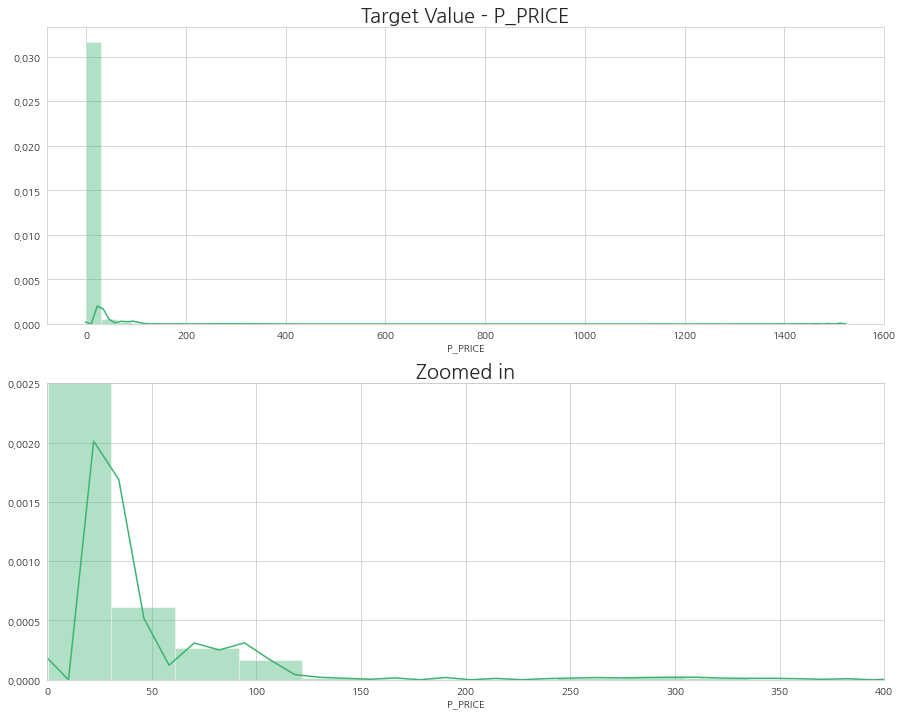

In [9]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
sns.distplot(df_eda['P_PRICE'], color='mediumseagreen')
plt.title("Target Value - P_PRICE",fontsize=title_size)

plt.subplot(2, 1, 2)
sns.distplot(df_eda['P_PRICE'], color='mediumseagreen')
plt.xlim([0, 400])
plt.ylim([0, 0.0025])
plt.title("Zoomed in",fontsize=title_size)

plt.show()

- 42703 data sets
- 평균, Q1, Q2, Q3 값에 비해 최대값이 매우 크고, std가 굉장히 큰 것으로 보아 치우쳐져서 분포하고 있음을 유추할 수 있다
- 75%의 값들은 10 미만

- 대부분의 값들이 50 보다 작은 값을 가지고 있음
- 대부분의 값들이 130 보다 작은 값을 가지고 있음
- 큰 값들의 공통점을 찾아보면 좋을듯

## REG_DATE
기준일

In [10]:
df_eda[['REG_DATE']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42073 entries, 0 to 42072
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   REG_DATE  42073 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 328.8 KB


In [11]:
df_eda.REG_DATE.describe()

count                   42073
unique                    210
top       2017-09-25 00:00:00
freq                      255
first     2015-12-28 00:00:00
last      2019-12-30 00:00:00
Name: REG_DATE, dtype: object

- **datetime64** 형태
- 총 **42073** 개의 값
- Null 값은 존재하지 않음
- 210개의 다른 날짜 존재


In [12]:
print(len(df_eda), "data exists between", min(df_eda.REG_DATE), "~", max(df_eda.REG_DATE))

42073 data exists between 2015-12-28 00:00:00 ~ 2019-12-30 00:00:00


In [13]:
df_eda['date'] = df_eda['REG_DATE'].dt.year.astype('str') + df_eda['REG_DATE'].dt.month.astype('str').str.zfill(2)

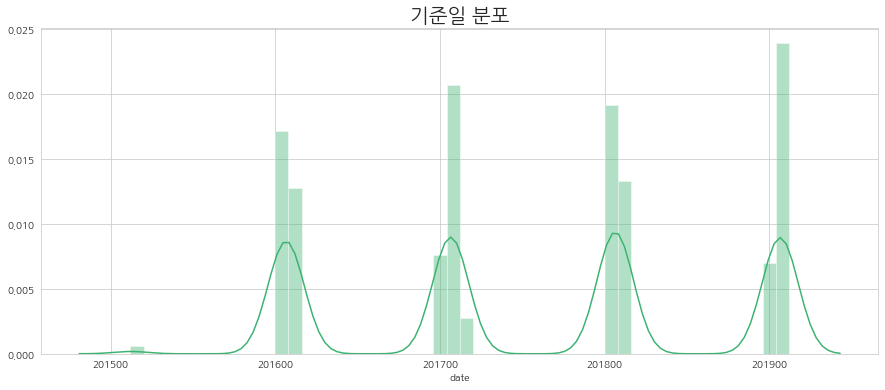

In [14]:
plt.figure(figsize=(15,6))
sns.distplot(df_eda['date'], color='mediumseagreen')
plt.title("기준일 분포",fontsize=title_size)
plt.show()

In [15]:
df_eda.groupby(df_eda['REG_DATE'].dt.year).count()

,REG_DATE,P_TYPE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE,date
REG_DATE,,,,,,,,,,,
2015,199,199,199,199,199,199,199,199,199,199,199
2016,10086,10086,10086,10086,10086,10086,10086,10086,10086,10086,10086
2017,10451,10451,10451,10451,10451,10451,10451,10451,10451,10451,10451
2018,10934,10934,10934,10934,10934,10934,10934,10934,10934,10934,10934
2019,10403,10403,10403,10403,10403,10403,10403,10403,10403,10403,10403


- 데이터양이 2015년을 제외하곤 년 별로 비슷하게 주어짐
- 2015년의 데이터가 사용할 수 있을만한 수준인지 살펴볼 필요

### 결론
시계열 데이터인 만큼 기준일은 필수적으로 봐야하는 값일 것이다  
그러나 기준일 자체가 가격에 영향을 미치기 보다는 그 해에 일어나는 여러가지 일들이 영향을 미치기에, 그 사건들의 발생 기준으로 봐야할 듯 하다

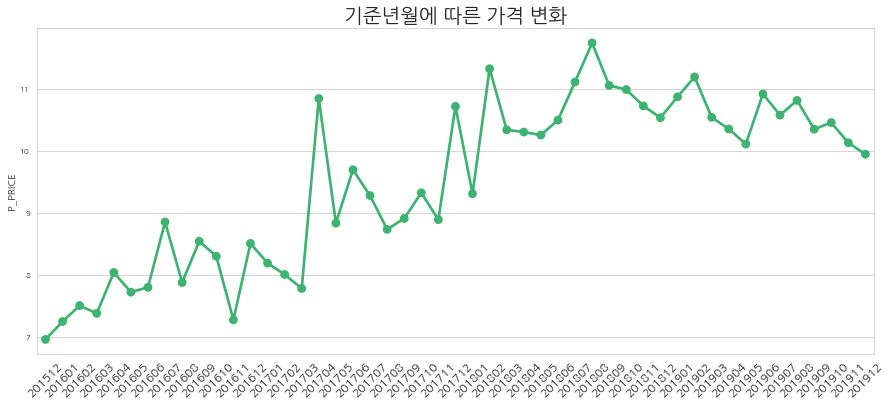

In [16]:
plt.figure(figsize=(15, 6))
sns.pointplot(x='date', y='P_PRICE', data=df_eda, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('기준년월에 따른 가격 변화', fontsize=title_size)
plt.show()

- 기준일에 따라 증가하는 경향성 존재

## P_TYPE
제품구분

In [17]:
df_eda.P_TYPE.describe()

count     42073
unique        1
top         수산물
freq      42073
Name: P_TYPE, dtype: object

### 결론
수산물 밖에 없어서 column 삭제 가능

In [18]:
df_eda.drop(columns = ['P_TYPE'], inplace=True)

## CTRY_1, CTRY_2
제조국, 수출국

In [19]:
df_eda.CTRY_1.describe()

count     42073
unique       87
top          중국
freq      11029
Name: CTRY_1, dtype: object

In [20]:
df_eda.CTRY_2.describe()

count     42073
unique       88
top          중국
freq      12008
Name: CTRY_2, dtype: object

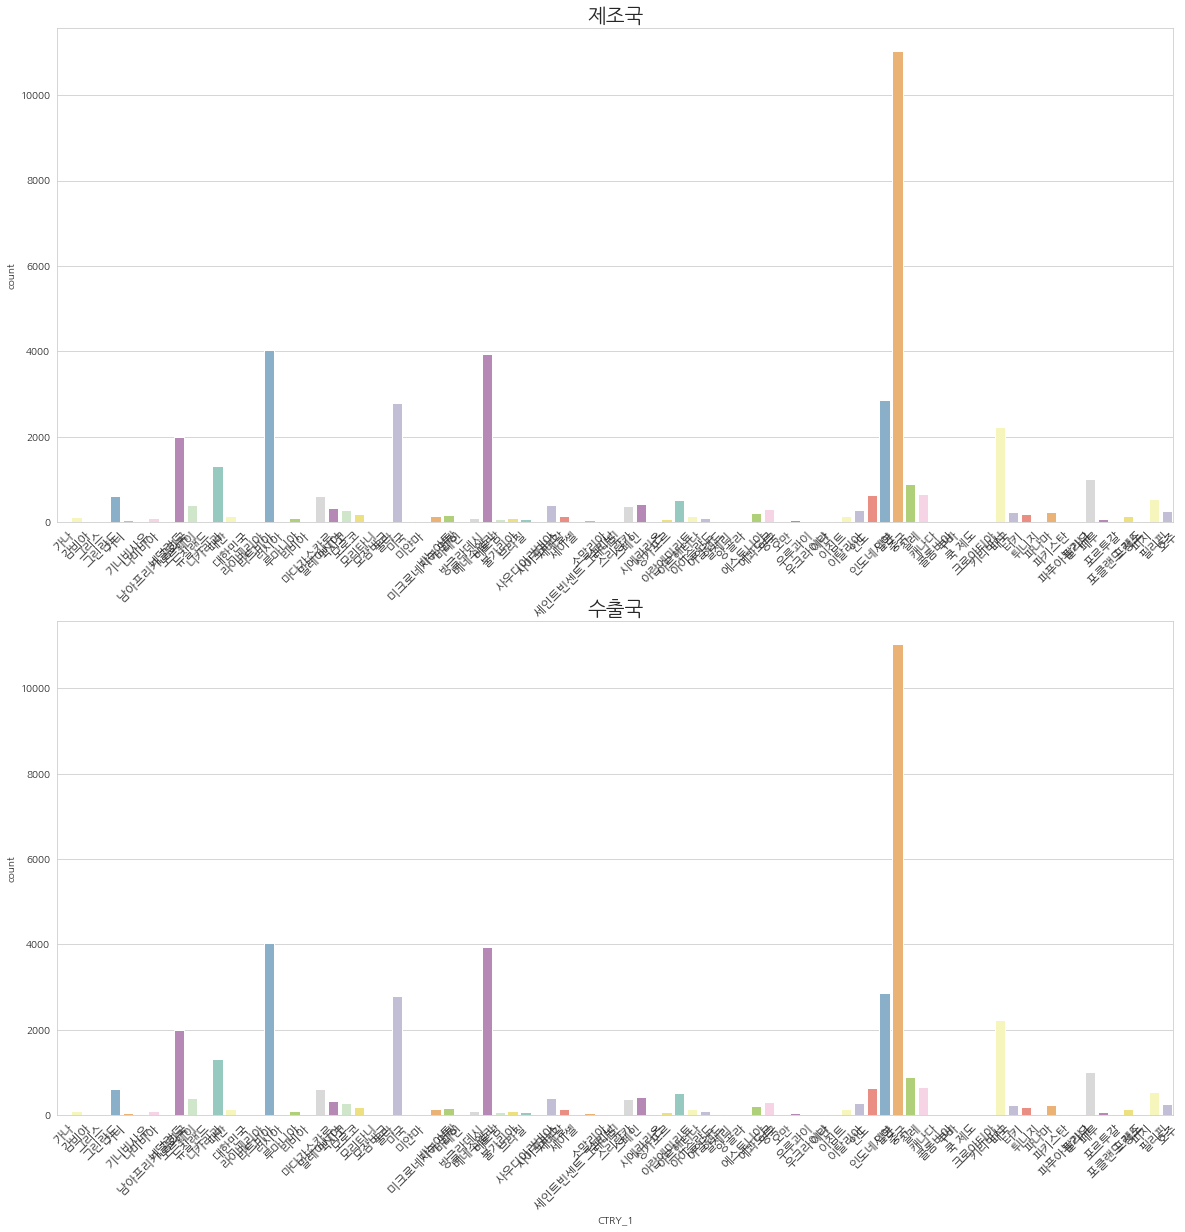

In [21]:
plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
sns.countplot(df_eda['CTRY_1'].astype('str').sort_values(), palette=color_palette)
plt.xticks(rotation=45, fontsize=12)
plt.title('제조국', fontsize=title_size)

plt.subplot(2, 1, 2)
sns.countplot(df_eda['CTRY_1'].astype('str').sort_values(), palette=color_palette)
plt.xticks(rotation=45, fontsize=12)
plt.title('수출국', fontsize=title_size)

plt.show()

많이 등장하는 나라도 있고 아닌 나라도 있고...  
따로 카테고리화는 데이터타입 변경으로 하기

In [22]:
df_eda['CTRY_1'] = df_eda['CTRY_1'].astype('category')
df_eda['CTRY_2'] = df_eda['CTRY_2'].astype('category')

In [23]:
df_eda['CTRY_1']

0        아르헨티나
1          바레인
2          바레인
3           칠레
4           중국
         ...  
42068      러시아
42069       중국
42070      러시아
42071       중국
42072     노르웨이
Name: CTRY_1, Length: 42073, dtype: category
Categories (87, object): [가나, 감비아, 그리스, 그린란드, ..., 프랑스, 피지, 필리핀, 호주]

제조국과 수입국이 다른 경우 가격 상승이 있을 수 있음

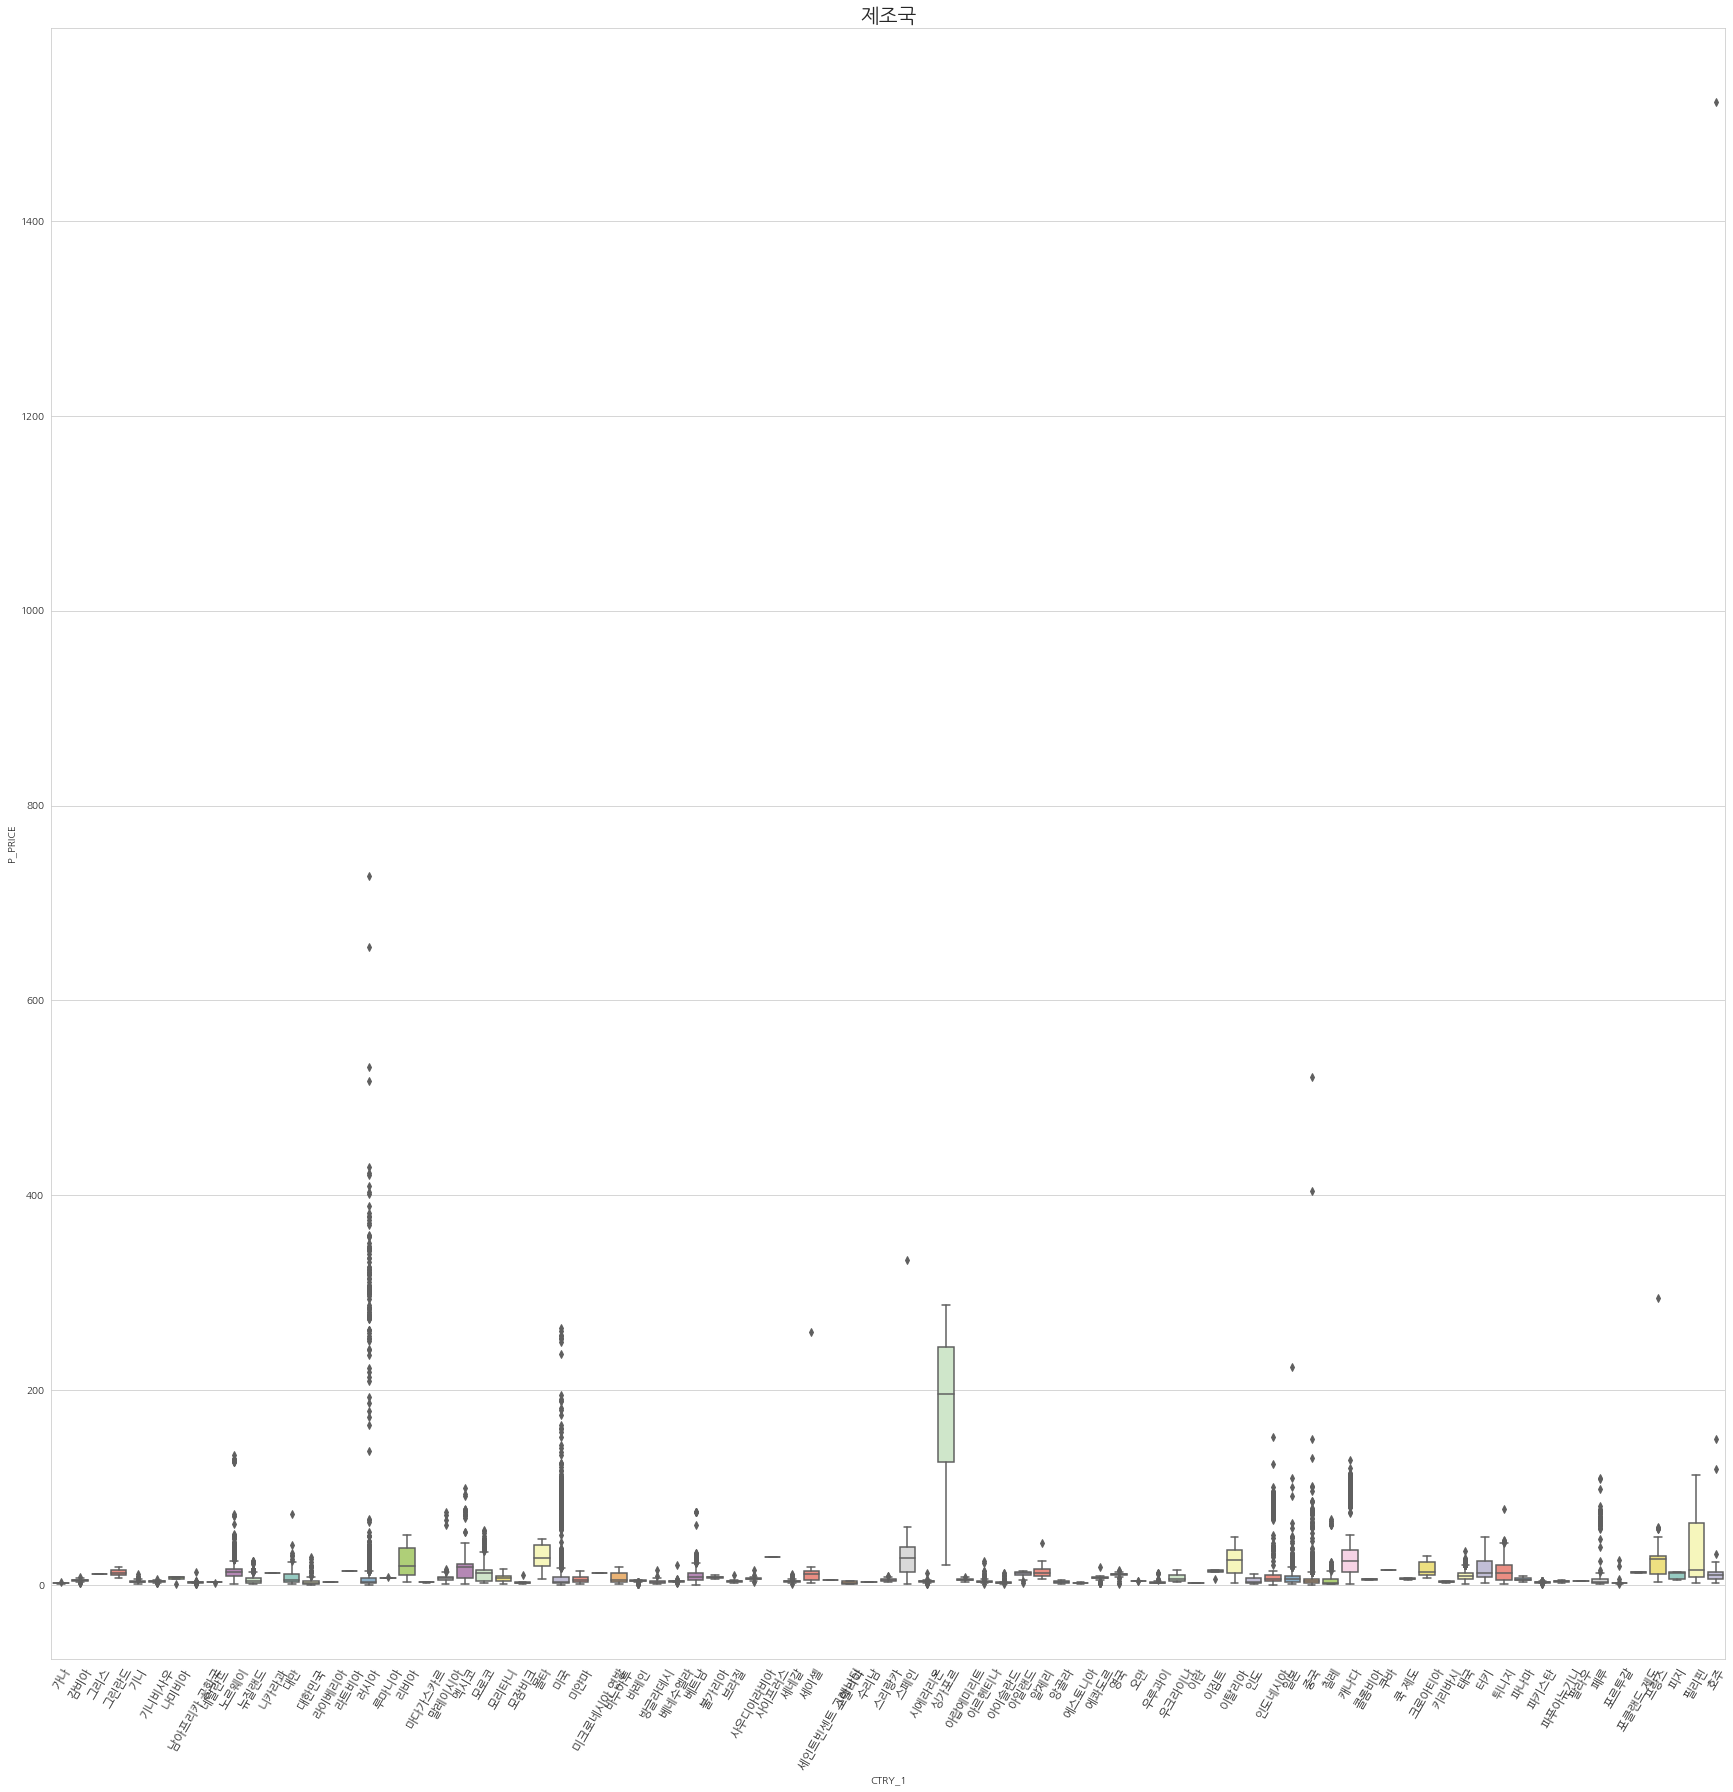

In [28]:
plt.figure(figsize=(30, 30))
sns.boxplot(x='CTRY_1', y='P_PRICE', data=df_eda, palette=color_palette)
plt.xticks(rotation=60, fontsize=12)
plt.title('제조국', fontsize=title_size)
plt.savefig(os.path.join(os.getcwd(), 'IMAGES', '제조국.png'), transparent=True)

training data에 대해서는 one hot encoding 바로 진행

## P_PURPOSE
수입용도

In [29]:
df_eda.P_PURPOSE.describe()

count     42073
unique        5
top         판매용
freq      39278
Name: P_PURPOSE, dtype: object

5가지의 수입용도가 있다

In [30]:
print(df_eda['P_PURPOSE'].value_counts())

판매용         39278
자사제품제조용      1726
외화획득용 원료      911
합작            144
반송품(기타)        14
Name: P_PURPOSE, dtype: int64


얘네는 카테고리화 할 수 있을 듯 (코드는 따로 보관)

In [31]:
df_eda['P_PURPOSE'] = df_eda['P_PURPOSE'].astype('category')

## CATEGORY_1
중분류명

In [32]:
df_eda.CATEGORY_1.describe()

count     42073
unique        7
top          어류
freq      21339
Name: CATEGORY_1, dtype: object

In [33]:
print(df_eda['CATEGORY_1'].value_counts())

어류             21339
갑각류             7298
연체류 해물모듬        6772
패류 멍게류          5097
알 곤이류           1037
젓갈류 해조류 해파리      467
기타 수입식품           63
Name: CATEGORY_1, dtype: int64


마찬가지로 카테고리화 진행해야하는데, 그 소분류부터 먼저 살펴보자

## CATEGORY_2
어종

In [34]:
df_eda.CATEGORY_2.describe()

count     42073
unique      113
top          새우
freq       4141
Name: CATEGORY_2, dtype: object

얘는 아마 CATEGORY_1 에 따라 소분류로 되어있는거라 합쳐서 생각해야할듯  
113 개 항목을 다 unique로 보면 안됨

In [35]:
with pd.option_context('display.max_rows', df_eda.shape[0]+1):
    display(df_eda[['CATEGORY_1', 'CATEGORY_2']].groupby(['CATEGORY_1', 'CATEGORY_2']).count())

Empty DataFrame
Columns: []
Index: [(갑각류, 가재 랍스타), (갑각류, 게), (갑각류, 새우), (기타 수입식품, 자라), (알 곤이류, 날치알), (알 곤이류, 대구알), (알 곤이류, 명란(명태알)), (알 곤이류, 샛돔류알), (알 곤이류, 성게알), (알 곤이류, 연어알), (알 곤이류, 열빙어(시샤모)알), (알 곤이류, 은민대구알), (알 곤이류, 청어알), (알 곤이류, 호키(새꼬리민태)알), (어류, 가물치), (어류, 가오리), (어류, 가자미), (어류, 갈치), (어류, 개복치), (어류, 고등어), (어류, 광어 넙치), (어류, 꽁치 학꽁치), (어류, 꽁치 확꽁치), (어류, 남극빙어), (어류, 노래미), (어류, 농어), (어류, 능성어 붉바리 바리), (어류, 달고기), (어류, 대구), (어류, 도다리), (어류, 도미 감성돔 돔류), (어류, 망둑어), (어류, 메기 동자개), (어류, 메로), (어류, 멸치), (어류, 명태), (어류, 물메기(곰치)), (어류, 미꾸라지), (어류, 민물붕어), (어류, 민어 점성어), (어류, 밀크피시), (어류, 방어), (어류, 밴댕이), (어류, 버터플라이 킹피쉬), (어류, 벤자리 알롱이), (어류, 병어), (어류, 보리멸), (어류, 복어), (어류, 부세), (어류, 붉평치(만다이 꽃돔)), (어류, 삼치), (어류, 상어 고래), (어류, 서대 박대 페루다), (어류, 송어), (어류, 쏘가리), (어류, 아귀), (어류, 양미리 정어리), (어류, 양태), (어류, 어류 기타), (어류, 연어), (어류, 열빙어(시샤모)), (어류, 옥돔), (어류, 우럭 볼락), (어류, 임연수), (어류, 잉어), (어류, 장어), (어류, 적어 눈볼대), (어류, 전갱기 매가리), (어류, 전갱이 매가리), (어류, 전어), (어류, 조기 보구치 강다리), (어류, 조기 보구치 강다리 ), (어류, 준치), (어류, 줄비늘치), (어류, 쥐치), (어류, 참치 새치류), (어류, 참치 새치류 ), (어류, 청어), (어류, 틸라피아(역돔)), (어류, 팡가시우스(홍메기)), (어류, 호끼류), (어류, 호키류), (어류, 홍어), (연체류 해물모듬, 갑오징어), (연체류 해물모듬, 꼴뚜기), (연체류 해물모듬, 낙지), (연체류 해물모듬, 문어), (연체류 해물모듬, 오징어), (연체류 해물모듬, 쭈꾸미), (연체류 해물모듬, 해물모둠), (젓갈류 해조류 해파리, 가사리), (젓갈류 해조류 해파리, 고시래기), (젓갈류 해조류 해파리, 김), (젓갈류 해조류 해파리, 다시마), (젓갈류 해조류 해파리, 미역), (젓갈류 해조류 해파리, 톳), (젓갈류 해조류 해파리, 해초), (젓갈류 해조류 해파리, 해파리), (패류 멍게류, 가리비), (패류 멍게류, 개불), ...]

카테고리화를 어떻게 시켜줘야 할지 모르겠음

## P_IMPORT_TYPE
수입형태

In [36]:
print(df_eda['P_IMPORT_TYPE'].value_counts())

냉동             13568
활               8280
냉장              4682
냉동,살,자숙         1431
냉동,살            1044
               ...  
냉동,눈살              2
냉동,자숙,절단,횟감        1
자숙,건조              1
냉장,간               1
건조,지느러미,자숙         1
Name: P_IMPORT_TYPE, Length: 78, dtype: int64


In [37]:
df_eda.P_IMPORT_TYPE.describe()

count     42073
unique       78
top          냉동
freq      13568
Name: P_IMPORT_TYPE, dtype: object

In [38]:
import_type_list = set()
for tmp in df_eda.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add(a)

In [39]:
print(*import_type_list)

눈살 지느러미 동체 턱살 외투막 훈제 절단 포장횟감 목살 냉동 꼬리_외화획득용 집게다리 슬라이스(S) 머리 개아지살 활 머리살 창난 자숙 간 한쪽껍질붙은 곤이 캐비아대용 껍질 알 살 볼살 건조 내장 줄기 난포선 다리 필렛(F) 냉장 횟감 머리_외화획득용 염장


- 비슷한 유형들이 있따 (머리 & 머리살 & 머리_외화획득용)
- 카테고리를 묶을 수 있을지 살펴보기
- 여러개의 용도로 들어오는 경우 고려... 용도의 수를 새로운 변수로 사용하면 좋을듯

수동 one hot encoding 진행해보자

In [40]:
for name in import_type_list:
    df_eda[name] = 0
    df_eda.loc[df_eda['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

In [41]:
df_eda['more_than_one_type'] = 0
df_eda.loc[df_eda[] + , 'more_than_one_type'] = 1

SyntaxError: invalid syntax (<ipython-input-41-92f5b0a3d597>, line 2)

In [ ]:
df_eda.drop(columns = ['P_IMPORT_TYPE'], inplace=True)

# 결론

In [42]:
df_eda.head(5)

,REG_DATE,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,CATEGORY_2,P_NAME,P_IMPORT_TYPE,P_PRICE,date,...,건조,내장,줄기,난포선,다리,필렛(F),냉장,횟감,머리_외화획득용,염장
0,2015-12-28,아르헨티나,아르헨티나,판매용,갑각류,새우,아르헨티나붉은새우,냉동,7.480000,201512,...,0,0,0,0,0,0,0,0,0,0
1,2015-12-28,바레인,바레인,판매용,갑각류,게,꽃게,냉동,2.920000,201512,...,0,0,0,0,0,0,0,0,0,0
2,2015-12-28,바레인,바레인,판매용,갑각류,게,꽃게,"냉동,절단",3.356352,201512,...,0,0,0,0,0,0,0,0,0,0
3,2015-12-28,칠레,칠레,판매용,패류 멍게류,해삼,해삼,"건조,자숙",18.260870,201512,...,1,0,0,0,0,0,0,0,0,0
4,2015-12-28,중국,중국,판매용,어류,서대 박대 페루다,서대,냉동,4.791340,201512,...,0,0,0,0,0,0,0,0,0,0


|ID|한글명|데이터 타입|형태|데이터 분류|영향도|중요도|비고|
|-|-|-|-|-|-|-|-|
|REG_DATE|기준일|datetime64|
|CTRY_1|제조국|varchar(255)|				
|CTRY_2|수출국|varchar(255)|				
|P_PURPOSE|수입용도|varchar(100)|				
|CATEGORY_1|중분류명|varchar(255)|					
|CATEGORY_2|어종|varchar(255)|			
|P_NAME|상세어종|varchar(255)|					
|P_IMPORT_TYPE|수입형태|varchar(100)|
|P_PRICE|평균단가|float|		

# Correlation

*Training data에 대해서는 one hot encoding 진행하기*

In [43]:
df_eda.columns

Index(['REG_DATE', 'CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2',
       'P_NAME', 'P_IMPORT_TYPE', 'P_PRICE', 'date', 'SAME_CTRY', '눈살', '지느러미',
       '동체', '턱살', '외투막', '훈제', '절단', '포장횟감', '목살', '냉동', '꼬리_외화획득용', '집게다리',
       '슬라이스(S)', '머리', '개아지살', '활', '머리살', '창난', '자숙', '간', '한쪽껍질붙은', '곤이',
       '캐비아대용', '껍질', '알', '살', '볼살', '건조', '내장', '줄기', '난포선', '다리', '필렛(F)',
       '냉장', '횟감', '머리_외화획득용', '염장'],
      dtype='object')

In [44]:
df_train = pd.get_dummies(df_eda, columns=['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2'])

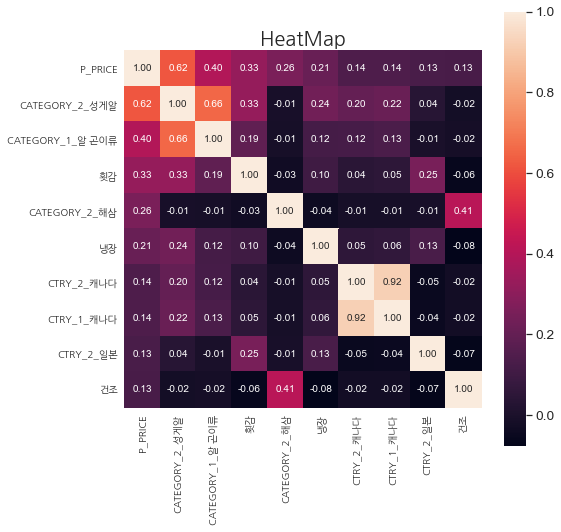

In [45]:
k = 10 #number of variables for heatmap
cols = df_train.corr().nlargest(k, 'P_PRICE')['P_PRICE'].index
cm = np.corrcoef(df_train[cols].values.T)
plt.figure(figsize=(8, 8))
plt.title('HeatMap', fontsize=title_size)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()